In [1]:
from dataset.dataset import *
from models.involution import * 
from models.unet import *

In [2]:
import math
import numpy as np
import torch 
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim

from PIL import Image
import glob

import matplotlib.pyplot as plt
import os 
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import datetime
import logging

In [3]:
import os
import torch 
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

## O Haze Dataset

In [4]:
class OHaze(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        self.haze_dir = os.path.join(data_dir, "hazy")
        self.clean_dir = os.path.join(data_dir, "GT")

        # Sort for consistency
        self.haze_images = sorted(os.listdir(self.haze_dir))  
        self.clean_images = sorted(os.listdir(self.clean_dir))  

        # Error handling if number of haze and clear images don't match
        if len(self.haze_images) != len(self.clean_images):
            raise ValueError("Number of haze images does not match number of clear images.")

    def __len__(self):
        return len(self.haze_images)

    def __getitem__(self, idx):
        haze_image_name = self.haze_images[idx]
        clean_image_name = self.clean_images[idx]
        haze_image_path = os.path.join(self.haze_dir, haze_image_name)
        clean_image_path = os.path.join(self.clean_dir, clean_image_name)

 
        haze_image = Image.open(haze_image_path)
        clean_image = Image.open(clean_image_path)

        if self.transform:
            haze_image = self.transform(haze_image)
            clean_image = self.transform(clean_image)

        return haze_image, clean_image

In [5]:
# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_dir = './dataset/O-HAZE/# O-HAZY NTIRE 2018'
ohaze_dataset = OHaze(dataset_dir, transform)

In [6]:
len(ohaze_dataset)

45

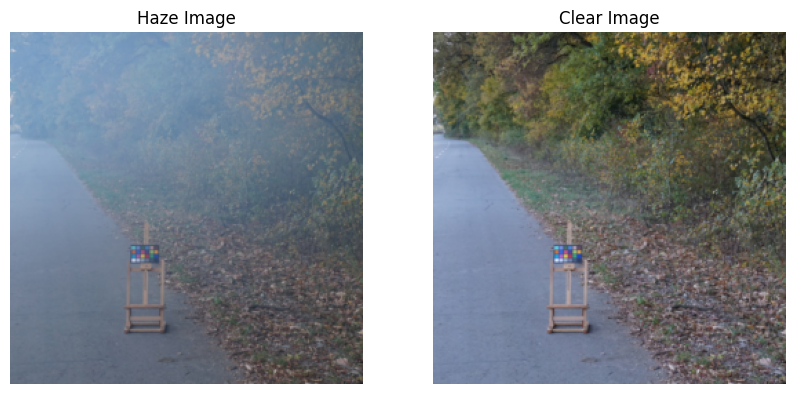

In [7]:
# Access an item from the dataset
index = 0  # Change this to test different images
haze_image, clear_image = ohaze_dataset[index]

# print(haze_image)
# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# Indices for splitting
total_size = len(ohaze_dataset)
indices = list(range(total_size))

# Split indices: 35 training, 5 validation, 5 test
train_indices, test_indices = train_test_split(indices, test_size=10, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=5, random_state=42)

print(f'Training indices: {len(train_indices)}')
print(f'Validation indices: {len(val_indices)}')
print(f'Test indices: {len(test_indices)}')

# Create Subset datasets
train_dataset = Subset(ohaze_dataset, train_indices)
val_dataset = Subset(ohaze_dataset, val_indices)
test_dataset = Subset(ohaze_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example usage
print("Number of training samples:", len(train_loader))
print("Number of validation samples:", len(val_loader))
print("Number of test samples:", len(test_loader))



Training indices: 35
Validation indices: 5
Test indices: 5
Number of training samples: 9
Number of validation samples: 5
Number of test samples: 5


In [9]:
from utils.metrics import psnr
from utils.train_evalute import *

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNET(in_channels = 3, out_channels = 3).to(device)
epochs = 100
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_path = './weights/model_20240517_032535.pth'
model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [11]:
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = os.path.join(log_dir, f"training_OHAZE_FT_{timestamp}.log")
val_logfile = os.path.join(log_dir, f"val_OHAZE_FT_{timestamp}.log")

def setup_logger(logger_name, log_file, level=logging.INFO):
    """Function to setup logger"""

    logger = logging.getLogger(logger_name)
    # Create a custom logger
    handler = logging.FileHandler(log_file)    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    
    handler.setFormatter(formatter)

    logger.setLevel(level)
    logger.addHandler(handler)
    
    return logger

train_log = setup_logger('train_log', log_file)
val_log = setup_logger('val_log', val_logfile)

In [12]:
history = train_and_evaluate(model, train_loader, val_loader, criterion, 
                optimizer, epochs, device, train_log, val_log, batch_size = 1, fine_tune = 'OHAZE')

Training Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.0198, Val Loss: 0.0268, PSNR: 16.473237991333008, SSIM: 0.6164614498615265
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 2/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.0127, Val Loss: 0.0122, PSNR: 19.529489517211914, SSIM: 0.7453026890754699
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 3/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.0109, Val Loss: 0.0109, PSNR: 19.9603328704834, SSIM: 0.767929470539093
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 4/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.0092, Val Loss: 0.0105, PSNR: 20.24410629272461, SSIM: 0.7691350698471069
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 5/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.0101, Val Loss: 0.0094, PSNR: 20.69692039489746, SSIM: 0.786828875541687
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 6/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.0081, Val Loss: 0.0087, PSNR: 21.177595138549805, SSIM: 0.7919404149055481
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 7/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.0072, Val Loss: 0.0091, PSNR: 20.97279930114746, SSIM: 0.7993406176567077
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 8/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.0078, Val Loss: 0.0090, PSNR: 20.962230682373047, SSIM: 0.8072276711463928
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 9/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.0072, Val Loss: 0.0089, PSNR: 21.140426635742188, SSIM: 0.8034234166145324
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 10/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.0070, Val Loss: 0.0086, PSNR: 21.33062744140625, SSIM: 0.8039489626884461
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 11/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.0066, Val Loss: 0.0085, PSNR: 21.469022750854492, SSIM: 0.8048737168312072
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 12/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.0067, Val Loss: 0.0079, PSNR: 21.511018753051758, SSIM: 0.8133060216903687
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 13/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.0075, Val Loss: 0.0080, PSNR: 21.5675106048584, SSIM: 0.8124846935272216
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 14/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.0063, Val Loss: 0.0081, PSNR: 21.6740665435791, SSIM: 0.8105965852737427
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 15/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.0061, Val Loss: 0.0082, PSNR: 21.750051498413086, SSIM: 0.8108154773712158
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 16/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.0064, Val Loss: 0.0078, PSNR: 21.85627555847168, SSIM: 0.8138400912284851
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 17/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.0059, Val Loss: 0.0083, PSNR: 21.46516990661621, SSIM: 0.8121623754501343
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 18/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.0057, Val Loss: 0.0087, PSNR: 21.376564025878906, SSIM: 0.8068806767463684
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 19/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.0050, Val Loss: 0.0083, PSNR: 21.675880432128906, SSIM: 0.8146181344985962
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 20/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.0054, Val Loss: 0.0085, PSNR: 21.82196617126465, SSIM: 0.8132506489753724
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 21/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.0057, Val Loss: 0.0086, PSNR: 21.54300308227539, SSIM: 0.8136777400970459
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 22/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.0054, Val Loss: 0.0086, PSNR: 21.5410213470459, SSIM: 0.8092242121696472
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 23/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 0.0052, Val Loss: 0.0083, PSNR: 21.448118209838867, SSIM: 0.8184979438781739
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 24/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 0.0055, Val Loss: 0.0086, PSNR: 21.692529678344727, SSIM: 0.8156615376472474
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 25/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 0.0047, Val Loss: 0.0087, PSNR: 21.497804641723633, SSIM: 0.8168710231781006
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 26/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 0.0050, Val Loss: 0.0088, PSNR: 21.626266479492188, SSIM: 0.8145525932312012
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 27/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 0.0049, Val Loss: 0.0087, PSNR: 21.69642448425293, SSIM: 0.8171816110610962
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 28/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 0.0054, Val Loss: 0.0081, PSNR: 21.813894271850586, SSIM: 0.8222576379776001
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 29/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/100
Train Loss: 0.0046, Val Loss: 33.5649, PSNR: 12.508890151977539, SSIM: 0.8191647052764892
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 30/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/100
Train Loss: 0.0050, Val Loss: 0.0193, PSNR: 19.349143981933594, SSIM: 0.8214688777923584
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 31/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/100
Train Loss: 0.0044, Val Loss: 0.0079, PSNR: 21.9343318939209, SSIM: 0.8238434672355652
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 32/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/100
Train Loss: 0.0043, Val Loss: 0.0086, PSNR: 21.909435272216797, SSIM: 0.8206762671470642
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 33/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/100
Train Loss: 0.0041, Val Loss: 0.0082, PSNR: 21.84175682067871, SSIM: 0.8250134825706482
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 34/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/100
Train Loss: 0.0043, Val Loss: 0.0086, PSNR: 21.90387535095215, SSIM: 0.824057137966156
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 35/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/100
Train Loss: 0.0042, Val Loss: 0.0090, PSNR: 21.7078800201416, SSIM: 0.8202358484268188
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 36/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/100
Train Loss: 0.0045, Val Loss: 0.0088, PSNR: 21.806997299194336, SSIM: 0.8213219761848449
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 37/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/100
Train Loss: 0.0041, Val Loss: 0.0086, PSNR: 21.994977951049805, SSIM: 0.8253223776817322
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 38/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/100
Train Loss: 0.0041, Val Loss: 0.0091, PSNR: 21.974872589111328, SSIM: 0.8216735243797302
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 39/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/100
Train Loss: 0.0040, Val Loss: 0.0086, PSNR: 21.879972457885742, SSIM: 0.8279141902923584
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 40/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/100
Train Loss: 0.0046, Val Loss: 0.0081, PSNR: 21.898792266845703, SSIM: 0.828831946849823
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 41/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/100
Train Loss: 0.0040, Val Loss: 0.0089, PSNR: 21.8653564453125, SSIM: 0.8227509498596192
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 42/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/100
Train Loss: 0.0046, Val Loss: 0.0083, PSNR: 21.70377540588379, SSIM: 0.8287998080253601
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 43/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/100
Train Loss: 0.0040, Val Loss: 0.0092, PSNR: 21.705110549926758, SSIM: 0.8227874875068665
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 44/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/100
Train Loss: 0.0040, Val Loss: 0.0077, PSNR: 21.939376831054688, SSIM: 0.8292404770851135
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 45/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/100
Train Loss: 0.0036, Val Loss: 0.0087, PSNR: 21.8211727142334, SSIM: 0.825536060333252
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 46/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/100
Train Loss: 0.0035, Val Loss: 0.0089, PSNR: 21.8298282623291, SSIM: 0.8278285145759583
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 47/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/100
Train Loss: 0.0034, Val Loss: 0.0096, PSNR: 21.822513580322266, SSIM: 0.8229274153709412
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 48/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/100
Train Loss: 0.0036, Val Loss: 0.0091, PSNR: 21.824583053588867, SSIM: 0.8265336632728577
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 49/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/100
Train Loss: 0.0034, Val Loss: 0.0093, PSNR: 21.910667419433594, SSIM: 0.8264219522476196
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 50/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/100
Train Loss: 0.0033, Val Loss: 0.0097, PSNR: 22.030057907104492, SSIM: 0.8244127035140991
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 51/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/100
Train Loss: 0.0033, Val Loss: 0.0086, PSNR: 22.110143661499023, SSIM: 0.8320204734802246
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 52/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/100
Train Loss: 0.0033, Val Loss: 0.0088, PSNR: 22.005666732788086, SSIM: 0.8300597667694092
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 53/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/100
Train Loss: 0.0032, Val Loss: 0.0089, PSNR: 21.884435653686523, SSIM: 0.8296085953712463
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 54/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/100
Train Loss: 0.0035, Val Loss: 0.0090, PSNR: 21.890947341918945, SSIM: 0.8277922987937927
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 55/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55/100
Train Loss: 0.0034, Val Loss: 0.0095, PSNR: 21.179452896118164, SSIM: 0.8349616408348084
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 56/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56/100
Train Loss: 0.0035, Val Loss: 0.0086, PSNR: 22.247730255126953, SSIM: 0.8330841898918152
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 57/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57/100
Train Loss: 0.0034, Val Loss: 0.0082, PSNR: 22.205581665039062, SSIM: 0.8360448241233825
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 58/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58/100
Train Loss: 0.0036, Val Loss: 0.0081, PSNR: 22.050064086914062, SSIM: 0.8364819169044495
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 59/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59/100
Train Loss: 0.0033, Val Loss: 0.0081, PSNR: 21.992801666259766, SSIM: 0.8369915962219239
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 60/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60/100
Train Loss: 0.0030, Val Loss: 0.0078, PSNR: 22.366186141967773, SSIM: 0.8363446712493896
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 61/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61/100
Train Loss: 0.0031, Val Loss: 0.0082, PSNR: 22.139551162719727, SSIM: 0.8330376744270325
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 62/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62/100
Train Loss: 0.0031, Val Loss: 0.0085, PSNR: 22.120969772338867, SSIM: 0.8321834444999695
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 63/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63/100
Train Loss: 0.0031, Val Loss: 0.0085, PSNR: 22.054927825927734, SSIM: 0.8350776791572571
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 64/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64/100
Train Loss: 0.0036, Val Loss: 0.0079, PSNR: 22.145429611206055, SSIM: 0.8374189257621765
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 65/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65/100
Train Loss: 0.0032, Val Loss: 0.0092, PSNR: 21.810667037963867, SSIM: 0.829953932762146
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 66/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66/100
Train Loss: 0.0029, Val Loss: 0.0087, PSNR: 21.881183624267578, SSIM: 0.8341941237449646
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 67/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67/100
Train Loss: 0.0030, Val Loss: 0.0095, PSNR: 21.8131160736084, SSIM: 0.8276933193206787
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 68/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68/100
Train Loss: 0.0036, Val Loss: 0.0088, PSNR: 21.971511840820312, SSIM: 0.8348315358161926
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 69/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69/100
Train Loss: 0.0029, Val Loss: 0.0089, PSNR: 22.120380401611328, SSIM: 0.834174656867981
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 70/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70/100
Train Loss: 0.0030, Val Loss: 0.0084, PSNR: 22.160337448120117, SSIM: 0.8359307765960693
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 71/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71/100
Train Loss: 0.0030, Val Loss: 0.0075, PSNR: 22.202163696289062, SSIM: 0.8412447690963745
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 72/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72/100
Train Loss: 0.0031, Val Loss: 0.0083, PSNR: 22.28790855407715, SSIM: 0.8355411887168884
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 73/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73/100
Train Loss: 0.0030, Val Loss: 0.0078, PSNR: 22.296539306640625, SSIM: 0.8395823955535888
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 74/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74/100
Train Loss: 0.0029, Val Loss: 0.0084, PSNR: 21.966779708862305, SSIM: 0.8360904097557068
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 75/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75/100
Train Loss: 0.0029, Val Loss: 0.0084, PSNR: 22.08513641357422, SSIM: 0.8366721868515015
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 76/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76/100
Train Loss: 0.0028, Val Loss: 0.0093, PSNR: 21.794240951538086, SSIM: 0.8296276450157165
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 77/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77/100
Train Loss: 0.0029, Val Loss: 0.0087, PSNR: 22.06591796875, SSIM: 0.8350896120071412
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 78/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78/100
Train Loss: 0.0030, Val Loss: 0.0088, PSNR: 22.1345272064209, SSIM: 0.8333566069602967
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 79/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79/100
Train Loss: 0.0028, Val Loss: 0.0088, PSNR: 22.19523048400879, SSIM: 0.8350465059280395
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 80/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80/100
Train Loss: 0.0027, Val Loss: 0.0085, PSNR: 22.383798599243164, SSIM: 0.8383983254432679
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 81/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81/100
Train Loss: 0.0026, Val Loss: 0.0079, PSNR: 22.208192825317383, SSIM: 0.8422438383102417
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 82/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82/100
Train Loss: 0.0029, Val Loss: 0.0086, PSNR: 22.145660400390625, SSIM: 0.835163688659668
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 83/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83/100
Train Loss: 0.0028, Val Loss: 0.0080, PSNR: 22.500167846679688, SSIM: 0.8415152192115783
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 84/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84/100
Train Loss: 0.0026, Val Loss: 0.0082, PSNR: 22.337350845336914, SSIM: 0.8389214634895324
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 85/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85/100
Train Loss: 0.0028, Val Loss: 0.0082, PSNR: 22.1879825592041, SSIM: 0.8378244042396545
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 86/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86/100
Train Loss: 0.0026, Val Loss: 0.0084, PSNR: 22.29989242553711, SSIM: 0.8370457649230957
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 87/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87/100
Train Loss: 0.0027, Val Loss: 0.0084, PSNR: 22.101167678833008, SSIM: 0.8381019353866577
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 88/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88/100
Train Loss: 0.0028, Val Loss: 0.0089, PSNR: 22.01144027709961, SSIM: 0.8361593246459961
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 89/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89/100
Train Loss: 0.0025, Val Loss: 0.0087, PSNR: 22.11843490600586, SSIM: 0.837821364402771
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 90/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90/100
Train Loss: 0.0025, Val Loss: 0.0095, PSNR: 22.039804458618164, SSIM: 0.8328133463859558
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 91/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91/100
Train Loss: 0.0027, Val Loss: 0.0093, PSNR: 22.018817901611328, SSIM: 0.8342865467071533
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 92/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92/100
Train Loss: 0.0026, Val Loss: 0.0091, PSNR: 22.044809341430664, SSIM: 0.836144745349884
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 93/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93/100
Train Loss: 0.0025, Val Loss: 0.0093, PSNR: 22.138898849487305, SSIM: 0.8346962690353393
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 94/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94/100
Train Loss: 0.0025, Val Loss: 0.0086, PSNR: 22.161008834838867, SSIM: 0.841008472442627
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 95/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95/100
Train Loss: 0.0025, Val Loss: 0.0083, PSNR: 22.200464248657227, SSIM: 0.8429524898529053
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 96/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96/100
Train Loss: 0.0025, Val Loss: 0.0079, PSNR: 22.26771354675293, SSIM: 0.847319483757019
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 97/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97/100
Train Loss: 0.0026, Val Loss: 0.0083, PSNR: 22.319272994995117, SSIM: 0.8422708630561828
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 98/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98/100
Train Loss: 0.0024, Val Loss: 0.0079, PSNR: 22.380416870117188, SSIM: 0.8440941095352172
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 99/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99/100
Train Loss: 0.0026, Val Loss: 12.1813, PSNR: 13.876113891601562, SSIM: 0.8430575609207154
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 100/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100/100
Train Loss: 0.0028, Val Loss: 0.8695, PSNR: 15.973876953125, SSIM: 0.8408889532089233
Model saved as weights/model_OHAZE_20240517_055202.pth


In [17]:
valid_per_epoch(model, test_loader, criterion, device, 0, 
                    100, val_log, batch_size = 1, display = False)

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

(0.009808425419032573, tensor(20.5931, device='cuda:0'), 0.7894145250320435)